In [1]:
import os
import torch
import pandas as pd
import numpy as np

from torch.utils.data import Dataset, DataLoader, Sampler
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import torchaudio

from torchsummary import summary
# from thop import profile
from tqdm.notebook import tqdm

from lightning.pytorch import Trainer
from lightning.pytorch.loggers import CSVLogger

import librosa
import librosa.display
import matplotlib.pyplot as plt
import itertools

from sources.cluster_metric import *

from sources.base.google_speech_dataset import GoogleSpeechDataset
from sources.base.train_base import train
from sources.base.DSCNNModel import DSCNNModel

from sources.triplet.google_speech_dataset_triplet import GoogleSpeechDatasetTriplet
from sources.triplet.triplet_dataloader import TripletLoader
from sources.triplet.triplet_loss import TripletLoss
from sources.triplet.train_triplet import train_triplet
from sources.triplet.DSCNNModel_embed import DSCNNembedModel

from sources.lifted_structured.lifted_structured_loss import LiftedStructuredLoss
from sources.lifted_structured.train_lifted import train_lifted

from sources.n_pair.google_speech_dataset_npair import GoogleSpeechDatasetNpair
from sources.n_pair.npair_dataloader import ClassPairSampler
from sources.n_pair.npair_loss import NPairLoss
from sources.n_pair.train_npair import train_npair

from pytorch_metric_learning import losses

import pathlib
import random
import math

In [2]:
train_labels = ['four', 'on', 'nine', 'dog', 'marvin', 'eight', 'five', 'down', 'three', 'right', 'yes', 'backward', 'tree', 'zero', 'off', 'cat', 'up', 'bed', 'six', 'two']
test_labels = ['follow', 'house', 'one', 'left', 'sheila', 'happy', 'learn', 'forward', 'stop', 'visual', 'go', 'bird', 'no', 'seven', 'wow']

In [5]:
# Create csv file decribing googel_speech dataset
root_dir = "./speech_commands/"

subdirs = next(os.walk(root_dir))[1]
subdirs.remove("_background_noise_")
labels = subdirs

labels_csv_filename = "google_speech_labels.csv"
labels_csv = open(labels_csv_filename, "w")
labels_csv.write("filename,label\n")


train_labels_csv_filename = "google_speech_train_labels.csv"
train_labels_csv = open(train_labels_csv_filename, "w")
train_labels_csv.write("filename,label\n")


test_labels_csv_filename = "google_speech_test_labels.csv"
test_labels_csv = open(test_labels_csv_filename, "w")
test_labels_csv.write("filename,label\n")


for label in labels:
    label_dir = os.path.join(root_dir, label)

    for f in os.listdir(label_dir):
        labels_csv.write(f"{os.path.join(label, f)},{label}\n")


train_cnt = 0
for label in train_labels:
    label_dir = os.path.join(root_dir, label)

    i = 0
    for f in os.listdir(label_dir):
        train_labels_csv.write(f"{os.path.join(label, f)},{label}\n")
        # i += 1
        train_cnt += 1
        if (i > 100):
            break

test_cnt = 0
for label in test_labels:
    label_dir = os.path.join(root_dir, label)

    for f in os.listdir(label_dir):
        test_cnt += 1
        test_labels_csv.write(f"{os.path.join(label, f)},{label}\n")


labels_csv.close()
train_labels_csv.close()
test_labels_csv.close()

In [4]:
train_cnt

65768

In [7]:
65768 - 46037

19731

In [5]:
test_cnt

40061

## TRIPLET LOSS

### Margin = 1

In [ ]:
google_speech_dataset = GoogleSpeechDatasetTriplet(csv_file=train_labels_csv_filename, root_dir="./speech_commands/", transform=None)
# google_speech_dataset = GoogleSpeechDatasetTriplet(csv_file=train_labels_csv_filename, root_dir="./speech_commands/", transform=noise_transform)

train_size = int(0.7 * len(google_speech_dataset))
test_size = len(google_speech_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(google_speech_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

# train_dataset = GoogleSpeechDatasetTriplet(csv_file=train_labels_csv_filename, root_dir="./speech_commands/", transform=noise_transform, subset=train_dataset)
# test_dataset = GoogleSpeechDatasetTriplet(csv_file=train_labels_csv_filename, root_dir="./speech_commands/", transform=noise_transform, subset=test_dataset)

train_dataset = GoogleSpeechDatasetTriplet(csv_file=train_labels_csv_filename, root_dir="./speech_commands/", transform=None, subset=train_dataset)
test_dataset = GoogleSpeechDatasetTriplet(csv_file=train_labels_csv_filename, root_dir="./speech_commands/", transform=None, subset=test_dataset)

# Random Smaplers
train_indexes = np.arange(len(train_dataset))
validation_indexes = np.arange(len(test_dataset))

train_sampler = SubsetRandomSampler(train_indexes)
validation_sampler = SubsetRandomSampler(validation_indexes)

# Dataloaders
batch_size = 100

triplet_loader_train = TripletLoader(train_dataset, batch_size=100, shuffle=True)
triplet_loader_test = TripletLoader(test_dataset, batch_size=100, shuffle=True)

device = torch.device("cpu")

if torch.cuda.is_available():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print (x)
else:
    print ("cuda device not found.")


triplet_model = DSCNNembedModel().to(device)

# Adam cross entropy loss, lr = 5*10^-4
loss_fn = TripletLoss(margin=1)
learning_rate = 1e-4
optimizer = torch.optim.Adam(triplet_model.parameters(), lr=learning_rate)

In [ ]:
net = train_triplet(triplet_model, loss_fn, optimizer, 25, triplet_loader_train, triplet_loader_test, log_file='run_triplet_1', new_checkpoint_file='checkpoints/triplet_1/check', last_checkpoint_file=None, device=device)

### Margin = 2

In [ ]:
triplet_model = DSCNNembedModel().to(device)

# Adam cross entropy loss, lr = 5*10^-4
loss_fn = TripletLoss(margin=2)
learning_rate = 1e-4
optimizer = torch.optim.Adam(triplet_model.parameters(), lr=learning_rate)

In [ ]:
net = train_triplet(triplet_model, loss_fn, optimizer, 25, triplet_loader_train, triplet_loader_test, log_file='run_triplet_2', new_checkpoint_file='checkpoints/triplet_2/check', last_checkpoint_file=None, device=device)

### Margin = 5

In [ ]:
triplet_model = DSCNNembedModel().to(device)

# Adam cross entropy loss, lr = 5*10^-4
loss_fn = TripletLoss(margin=5)
learning_rate = 1e-4
optimizer = torch.optim.Adam(triplet_model.parameters(), lr=learning_rate)

In [ ]:
net = train_triplet(triplet_model, loss_fn, optimizer, 25, triplet_loader_train, triplet_loader_test, log_file='run_triplet_5', new_checkpoint_file='checkpoints/triplet_5/check', last_checkpoint_file=None, device=device)

### Margin = 10

In [ ]:
triplet_model = DSCNNembedModel().to(device)

# Adam cross entropy loss, lr = 5*10^-4
loss_fn = TripletLoss(margin=10)
learning_rate = 1e-4
optimizer = torch.optim.Adam(triplet_model.parameters(), lr=learning_rate)

In [ ]:
net = train_triplet(triplet_model, loss_fn, optimizer, 25, triplet_loader_train, triplet_loader_test, log_file='run_triplet_10', new_checkpoint_file='checkpoints/triplet_10/check', last_checkpoint_file=None, device=device)

## DS CNN MODEL

In [ ]:
google_speech_dataset = GoogleSpeechDataset(csv_file=train_labels_csv_filename, root_dir="./speech_commands/", transform=None)

train_size = int(0.7 * len(google_speech_dataset))
test_size = len(google_speech_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(google_speech_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

# Random Smaplers
train_indexes = np.arange(len(train_dataset))
validation_indexes = np.arange(len(test_dataset))

train_sampler = SubsetRandomSampler(train_indexes)
validation_sampler = SubsetRandomSampler(validation_indexes)

# Dataloaders
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = DataLoader(test_dataset, batch_size=batch_size * 10, sampler=validation_sampler)

device = torch.device("cpu")

if torch.cuda.is_available():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print (x)
else:
    print ("cuda device not found.")

class_number = 20
ds_cnn_model = DSCNNModel(class_number).to(device)

# Adam cross entropy loss, lr = 5*10^-4
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(ds_cnn_model.parameters(), lr=learning_rate)

In [ ]:
net = train(ds_cnn_model, loss_fn, optimizer, 25, train_loader, validation_loader, log_file='run_base', new_checkpoint_file='checkpoints/base/check', last_checkpoint_file=None, device=device)

## LIFTED STRUCTURED LOSS

### Margin = 1

In [ ]:
google_speech_dataset = GoogleSpeechDataset(csv_file=train_labels_csv_filename, root_dir="./speech_commands/", transform=None)

train_size = int(0.7 * len(google_speech_dataset))
test_size = len(google_speech_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(google_speech_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

# Random Smaplers
train_indexes = np.arange(len(train_dataset))
validation_indexes = np.arange(len(test_dataset))

train_sampler = SubsetRandomSampler(train_indexes)
validation_sampler = SubsetRandomSampler(validation_indexes)

# Dataloaders
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=validation_sampler)

device = torch.device("cpu")

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(device)
else:
    print ("cuda device not found.")


lifted_model = DSCNNembedModel().to(device)

# Adam cross entropy loss, lr = 5*10^-4
loss_fn =  LiftedStructuredLoss(margin=1)
learning_rate = 1e-4
optimizer = torch.optim.Adam(lifted_model.parameters(), lr=learning_rate)

In [ ]:
net = train_lifted(lifted_model, loss_fn, optimizer, 50, train_loader, validation_loader, log_file='run_lifted_1', new_checkpoint_file='checkpoints/lifted_1/check', last_checkpoint_file=None, device=device)

### Margin = 2

In [ ]:
lifted_model = DSCNNembedModel().to(device)

# Adam cross entropy loss, lr = 5*10^-4
loss_fn =  LiftedStructuredLoss(margin=2)
learning_rate = 1e-4
optimizer = torch.optim.Adam(lifted_model.parameters(), lr=learning_rate)

In [ ]:
net = train_lifted(lifted_model, loss_fn, optimizer, 50, train_loader, validation_loader, log_file='run_lifted_2', new_checkpoint_file='checkpoints/lifted_2/check', last_checkpoint_file=None, device=device)

### Margin = 5

In [ ]:
lifted_model = DSCNNembedModel().to(device)

# Adam cross entropy loss, lr = 5*10^-4
loss_fn =  LiftedStructuredLoss(margin=5)
learning_rate = 1e-4
optimizer = torch.optim.Adam(lifted_model.parameters(), lr=learning_rate)

In [ ]:
net = train_lifted(lifted_model, loss_fn, optimizer, 50, train_loader, validation_loader, log_file='run_lifted_5', new_checkpoint_file='checkpoints/lifted_5/check', last_checkpoint_file=None, device=device)

### Margin = 10

In [ ]:
lifted_model = DSCNNembedModel().to(device)

# Adam cross entropy loss, lr = 5*10^-4
loss_fn =  LiftedStructuredLoss(margin=10)
learning_rate = 1e-4
optimizer = torch.optim.Adam(lifted_model.parameters(), lr=learning_rate)

In [ ]:
net = train_lifted(lifted_model, loss_fn, optimizer, 50, train_loader, validation_loader, log_file='run_lifted_10', new_checkpoint_file='checkpoints/lifted_10/check', last_checkpoint_file=None, device=device)

## NPAIR LOSS

### N = 3

In [ ]:
google_speech_dataset = GoogleSpeechDataset(csv_file=train_labels_csv_filename, root_dir="./speech_commands/", transform=None)

train_size = int(0.7 * len(google_speech_dataset))
test_size = len(google_speech_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(google_speech_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

# Random Smaplers
train_indexes = np.arange(len(train_dataset))
validation_indexes = np.arange(len(test_dataset))

train_sampler = ClassPairSampler(train_dataset, train_indexes)
validation_sampler = ClassPairSampler(test_dataset, validation_indexes)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_sampler=train_sampler)
validation_loader = DataLoader(test_dataset, batch_sampler=validation_sampler)

device = torch.device("cpu")

if torch.cuda.is_available():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print (x)
else:
    print ("cuda device not found.")


npair_model = DSCNNembedModel().to(device)

# Adam cross entropy loss, lr = 5*10^-4
loss_fn = NPairLoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(npair_model.parameters(), lr=learning_rate)

In [ ]:
net = train_npair(npair_model, loss_fn, optimizer, 25, train_loader, validation_loader, log_file='run_npair_3', new_checkpoint_file='checkpoints/npair_3/check', last_checkpoint_file=None, device=device)

## TEST

In [6]:
from sklearn.manifold import TSNE

def plot_2d_data(data, labels_numerical, labels_text, file_name, title='Исходные данные', cmap='tab20', ax=None):
    '''
    Отрисовка 2d scatter plot. 
    :param np.ndarray data: 2d массив точек
    :param Union[list, np.ndarray] labels: список меток для каждой точки выборки
    :param str title: Заголовок графика
    :param str cmap: Цветовая палитра
    :param ax Optional[matplotlib.axes.Axes]: Оси для отрисовки графика.
        Если оси не заданы, то создаётся новая фигура и сразу же происходит её отрисовка
        Иначе, график добавляется на существуюущие оси. Отрисовки фигуры не происходит
    '''
    n_clusters = len(np.unique(labels_numerical))
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    else:
        fig = None
        
    scatter = ax.scatter(
        data[:, 0], data[:, 1], c=labels_numerical, 
        cmap=plt.get_cmap(cmap, n_clusters)
    )

    cbar = plt.colorbar(scatter, label='Кластер', ax=ax)
    cbar.set_ticks(np.min(labels_numerical) + (np.arange(n_clusters) + 0.5) * (n_clusters - 1) / n_clusters)
    cbar.set_ticklabels(np.unique(labels_text))

    ax.set_title(title)
    ax.grid(True)
    
    if fig is not None:
        fig.tight_layout()
        plt.show()

        fig.savefig(file_name, format='png')

In [10]:
google_speech_dataset = GoogleSpeechDataset(csv_file=test_labels_csv_filename, root_dir="./speech_commands/", transform=None)
indexes = np.arange(len(google_speech_dataset))
sampler = SubsetRandomSampler(indexes)
batch_size = 500
loader = DataLoader(google_speech_dataset, batch_size=batch_size, sampler=sampler)

In [11]:
device = torch.device("cpu")

if torch.cuda.is_available():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print (x)
else:
    print ("cuda device not found.")

cuda device not found.


started: ./checkpoints/lifted_1/check_0
X embed shape: torch.Size([500, 64])


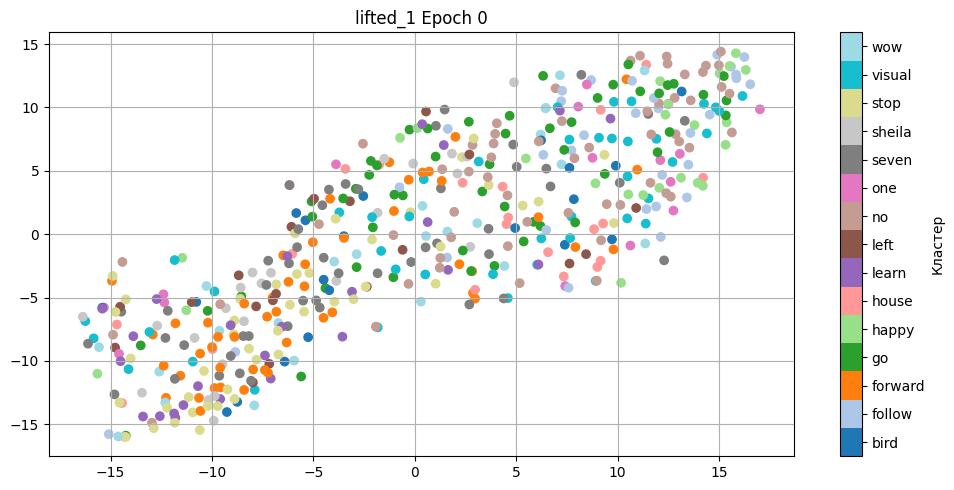

started: ./checkpoints/lifted_1/check_24
X embed shape: torch.Size([500, 64])


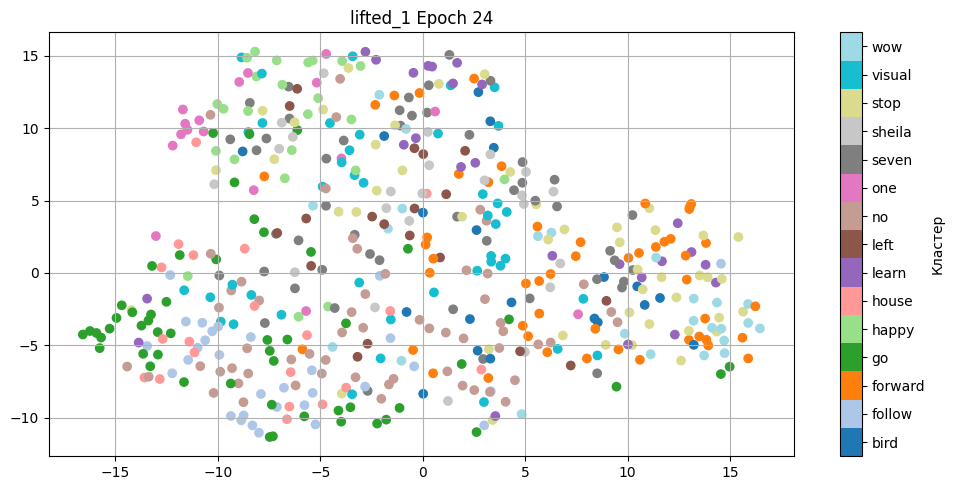

started: ./checkpoints/lifted_1/check_49
X embed shape: torch.Size([500, 64])


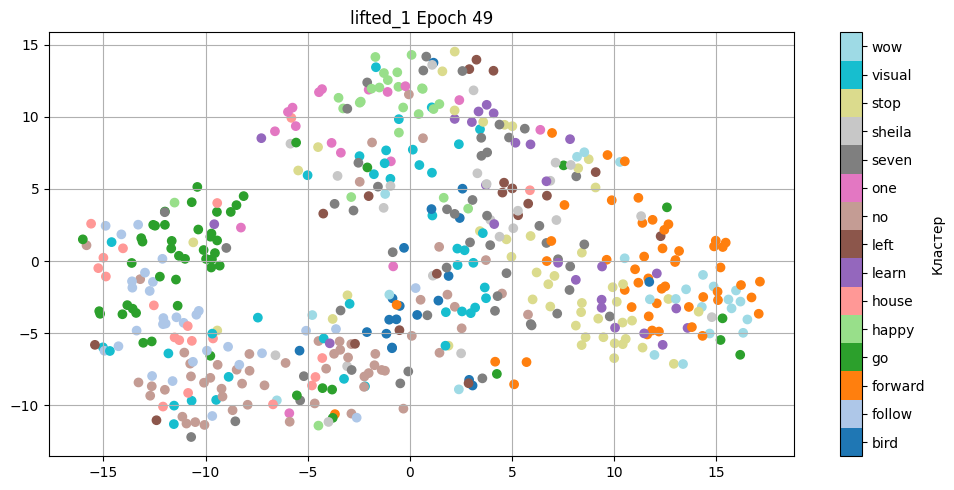

started: ./checkpoints/lifted_2/check_0
X embed shape: torch.Size([500, 64])


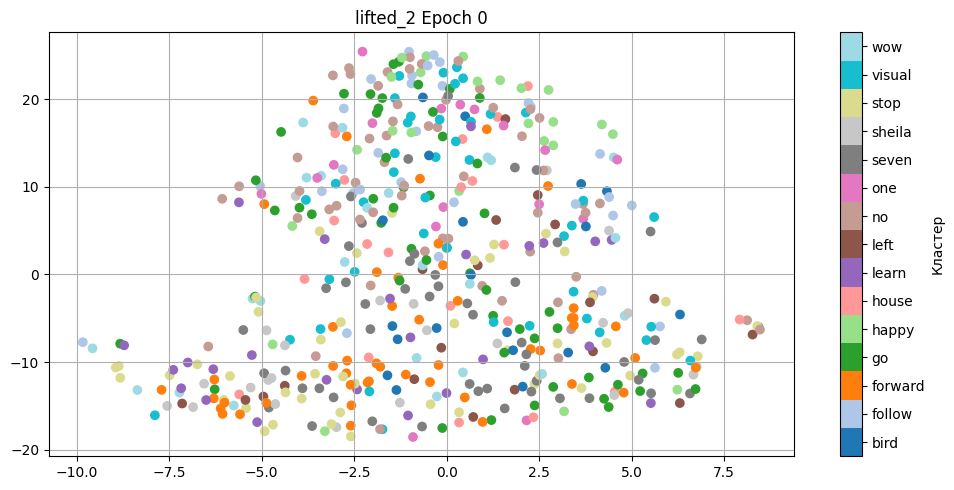

started: ./checkpoints/lifted_2/check_24
X embed shape: torch.Size([500, 64])


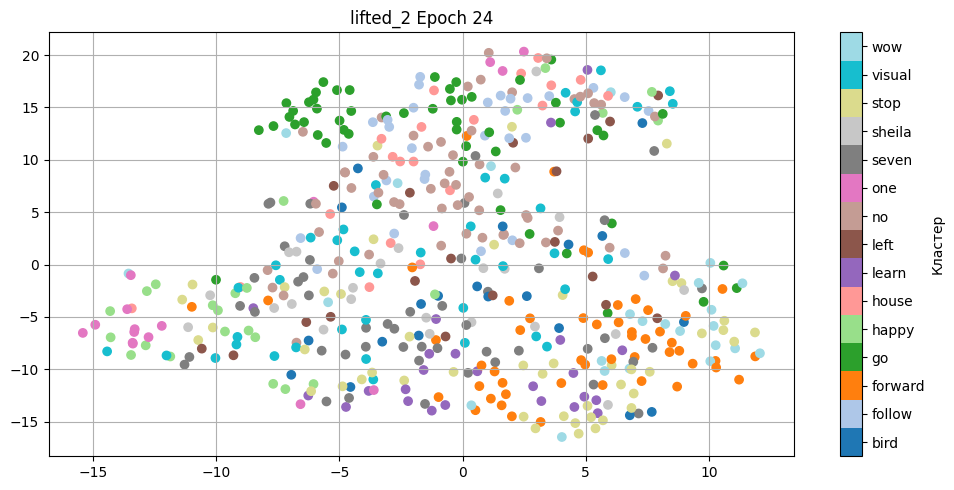

started: ./checkpoints/lifted_2/check_49
X embed shape: torch.Size([500, 64])


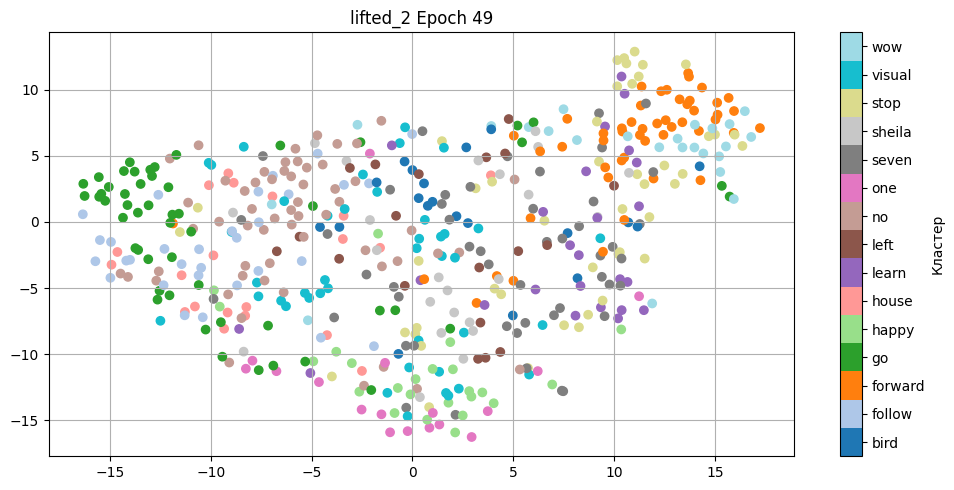

started: ./checkpoints/lifted_5/check_0
X embed shape: torch.Size([500, 64])


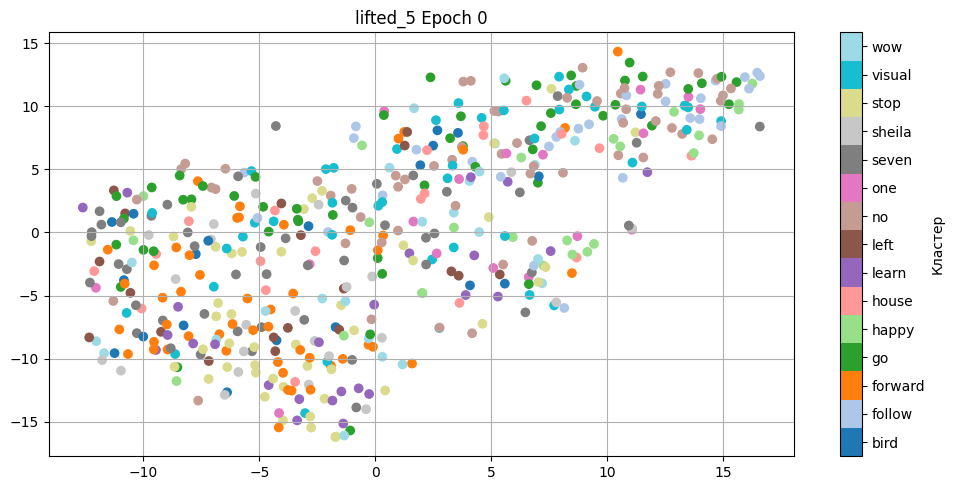

started: ./checkpoints/lifted_5/check_24
X embed shape: torch.Size([500, 64])


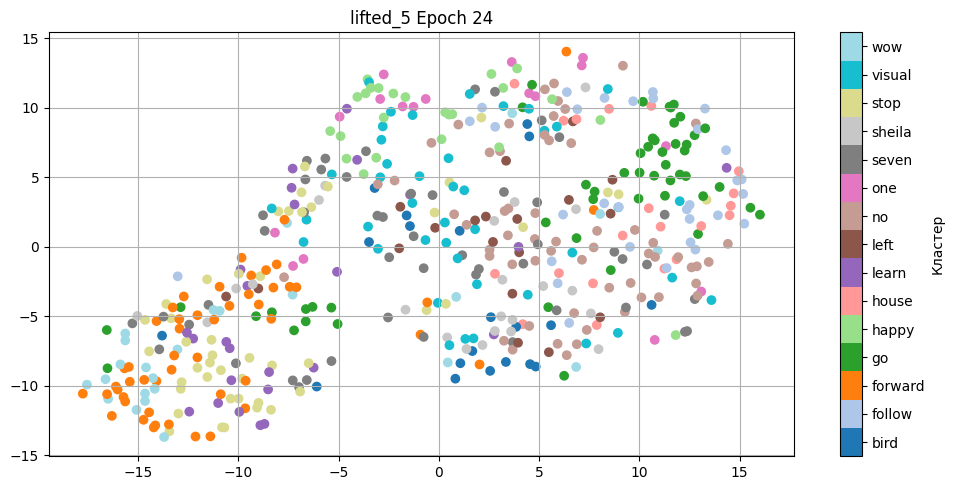

started: ./checkpoints/lifted_5/check_49
X embed shape: torch.Size([500, 64])


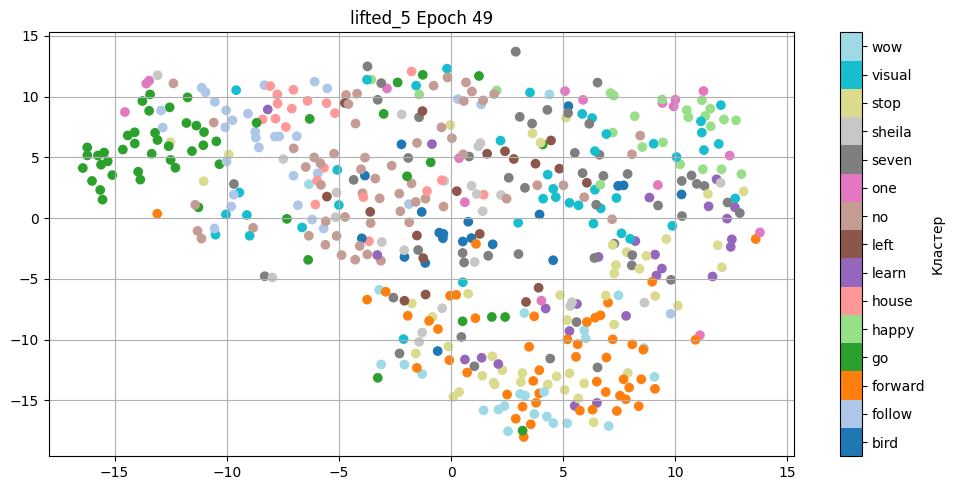

started: ./checkpoints/lifted_10/check_0
X embed shape: torch.Size([500, 64])


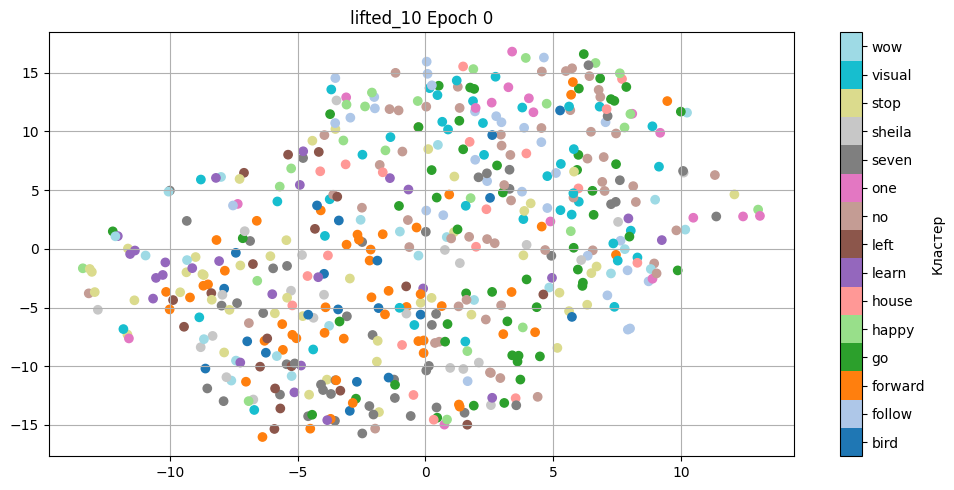

started: ./checkpoints/lifted_10/check_24
X embed shape: torch.Size([500, 64])


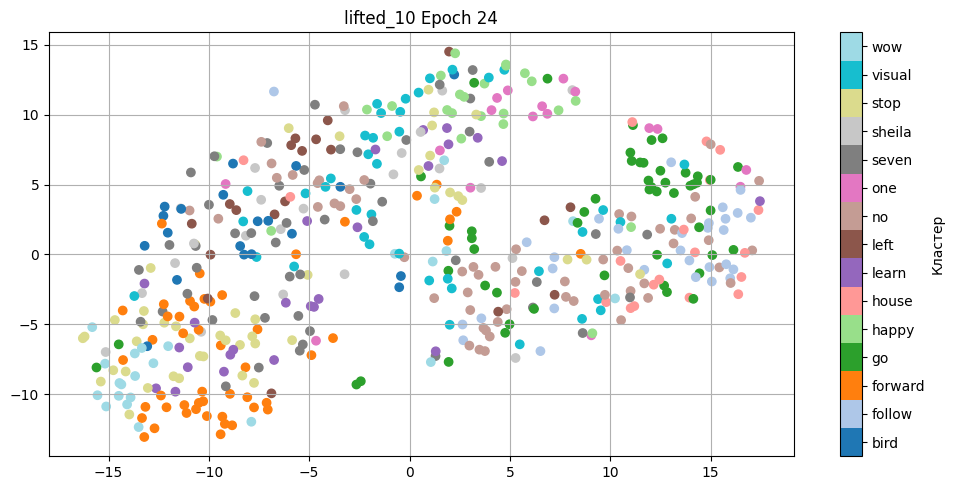

started: ./checkpoints/lifted_10/check_49
X embed shape: torch.Size([500, 64])


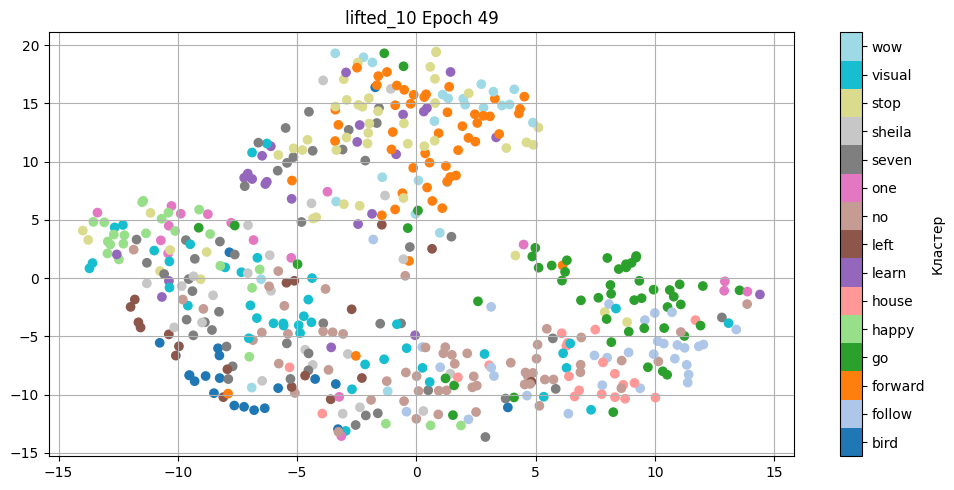

started: ./checkpoints/triplet_1/check_0
X embed shape: torch.Size([500, 64])


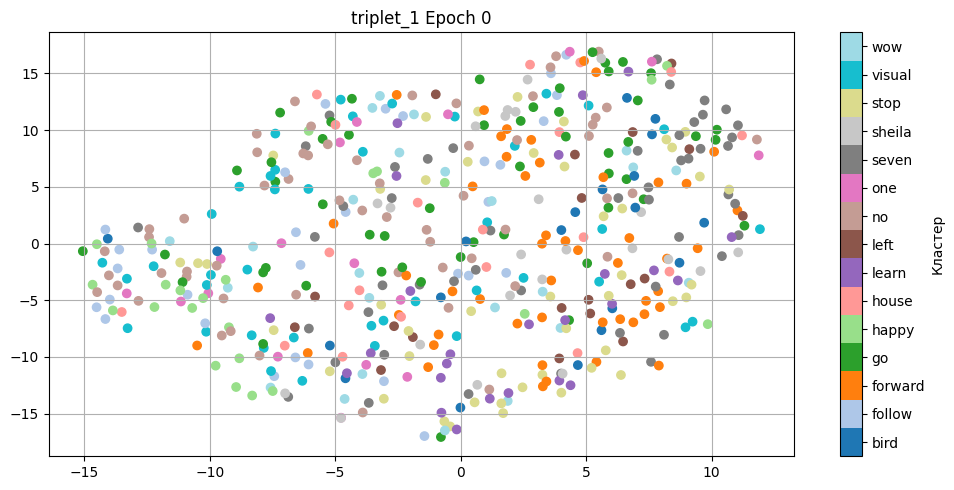

started: ./checkpoints/triplet_1/check_24
X embed shape: torch.Size([500, 64])


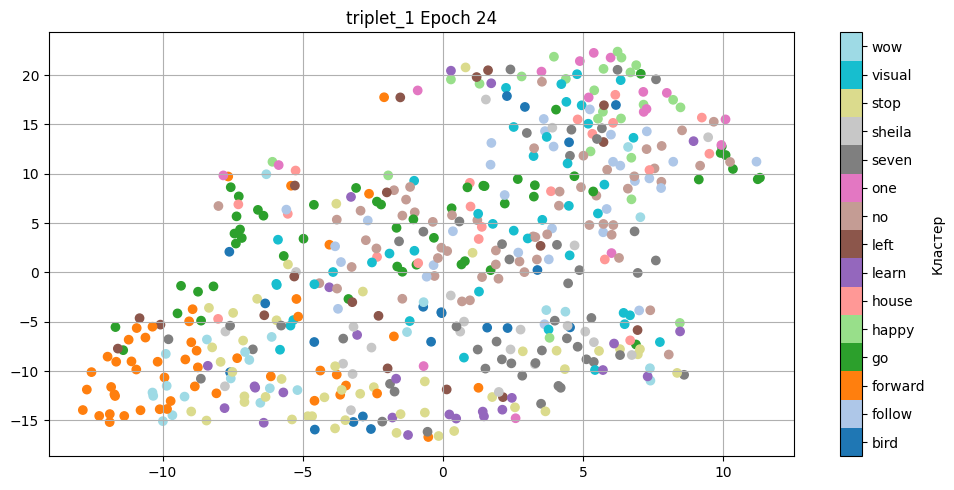

started: ./checkpoints/triplet_2/check_0
X embed shape: torch.Size([500, 64])


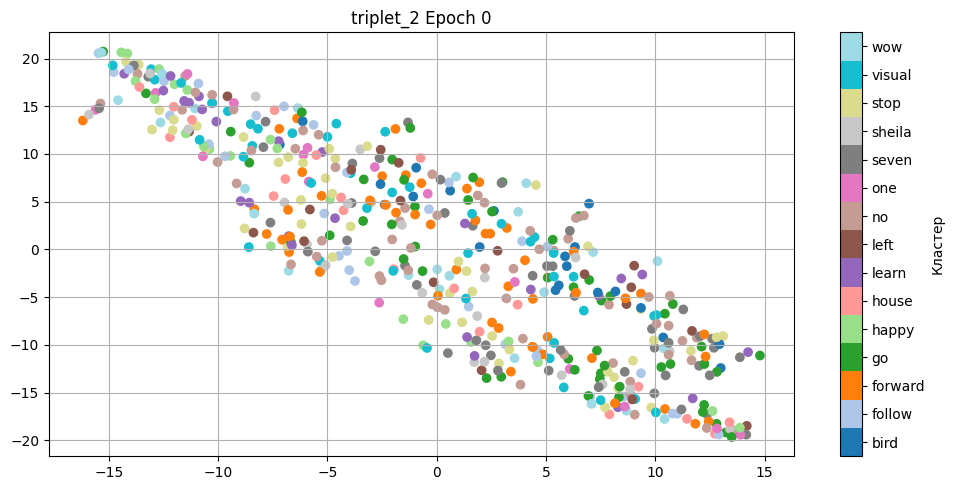

started: ./checkpoints/triplet_2/check_24
X embed shape: torch.Size([500, 64])


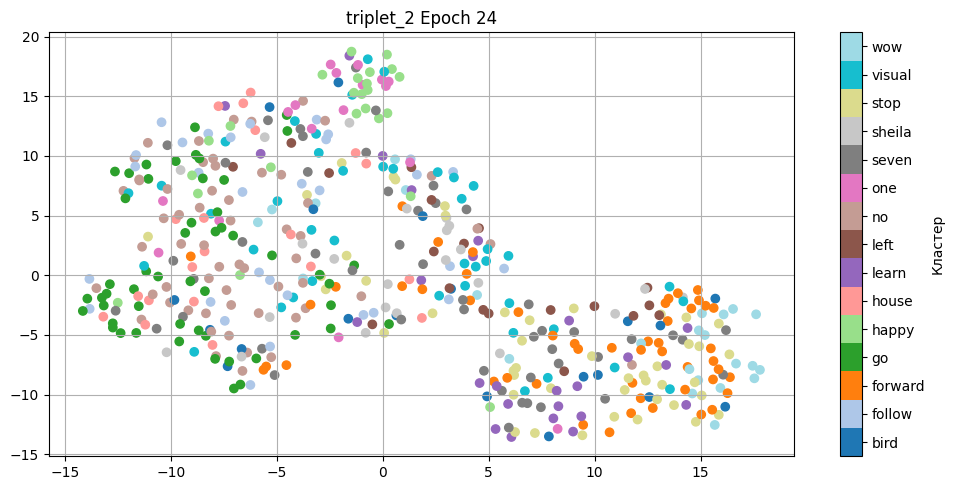

started: ./checkpoints/triplet_5/check_0
X embed shape: torch.Size([500, 64])


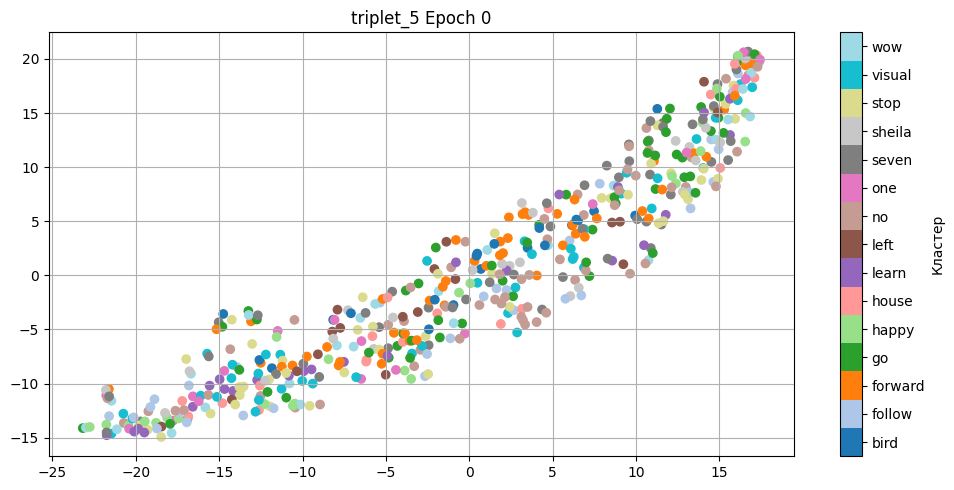

started: ./checkpoints/triplet_5/check_24
X embed shape: torch.Size([500, 64])


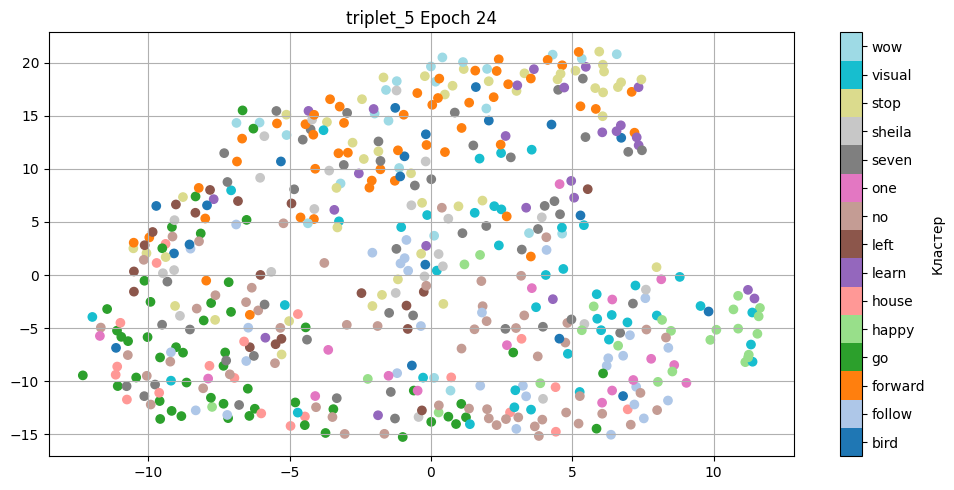

started: ./checkpoints/triplet_10/check_0
X embed shape: torch.Size([500, 64])


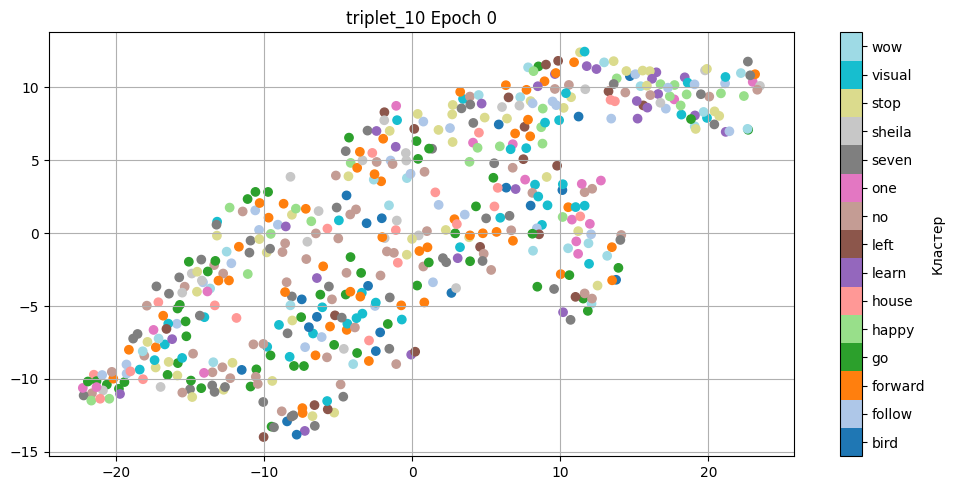

started: ./checkpoints/triplet_10/check_24
X embed shape: torch.Size([500, 64])


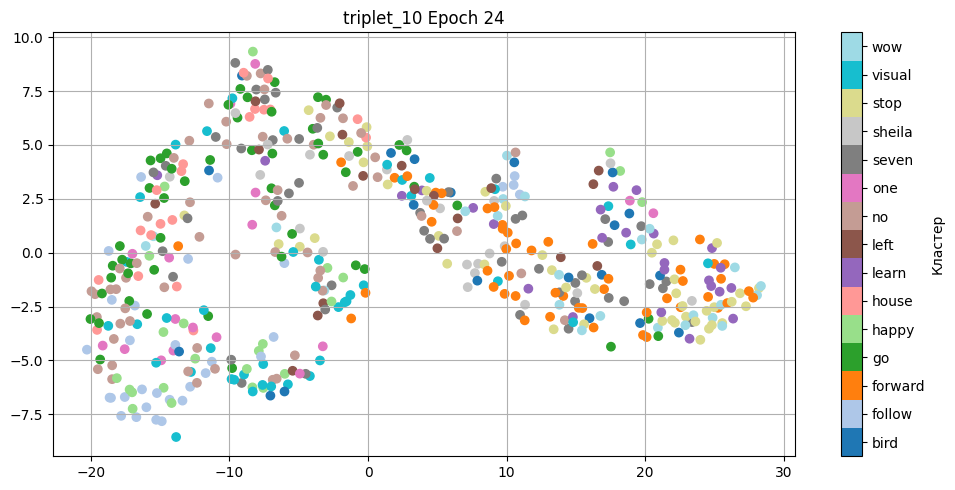

started: ./checkpoints/npair_3/check_0
X embed shape: torch.Size([500, 64])


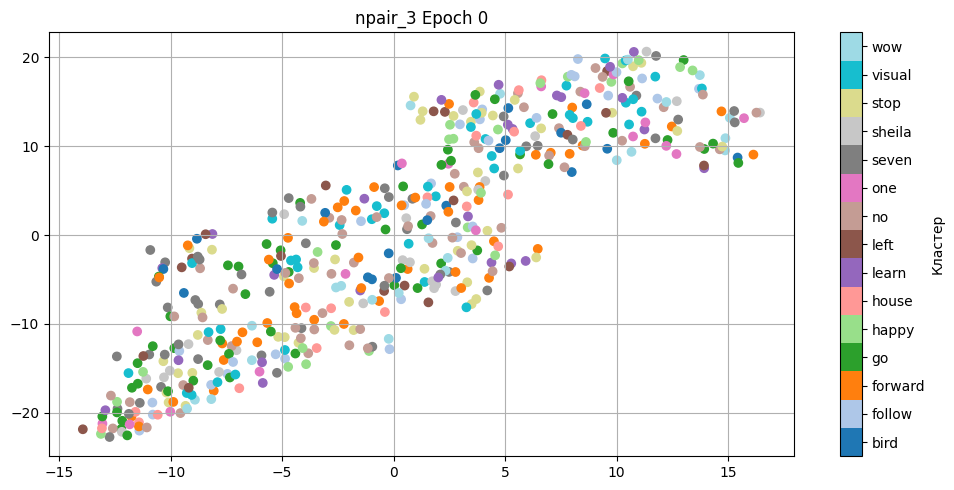

started: ./checkpoints/npair_3/check_24
X embed shape: torch.Size([500, 64])


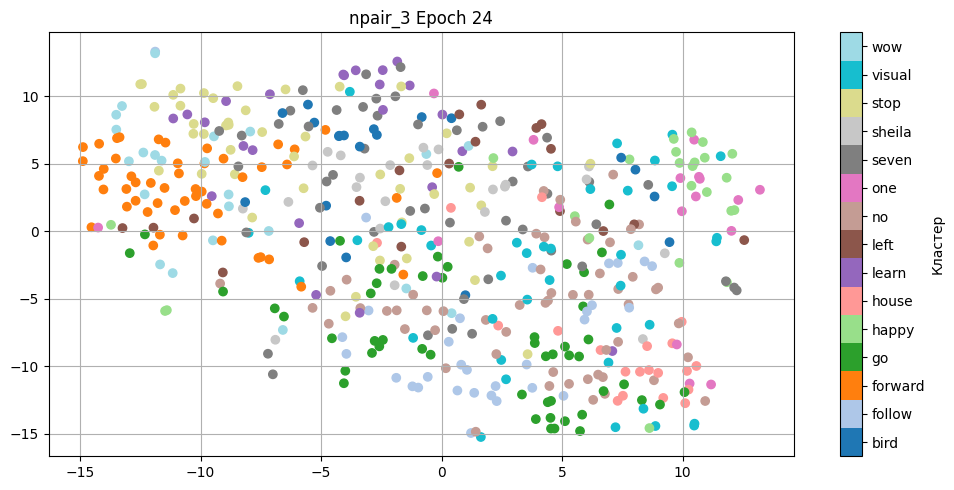

started: ./checkpoints/base/check_0
X embed shape: torch.Size([500, 64])


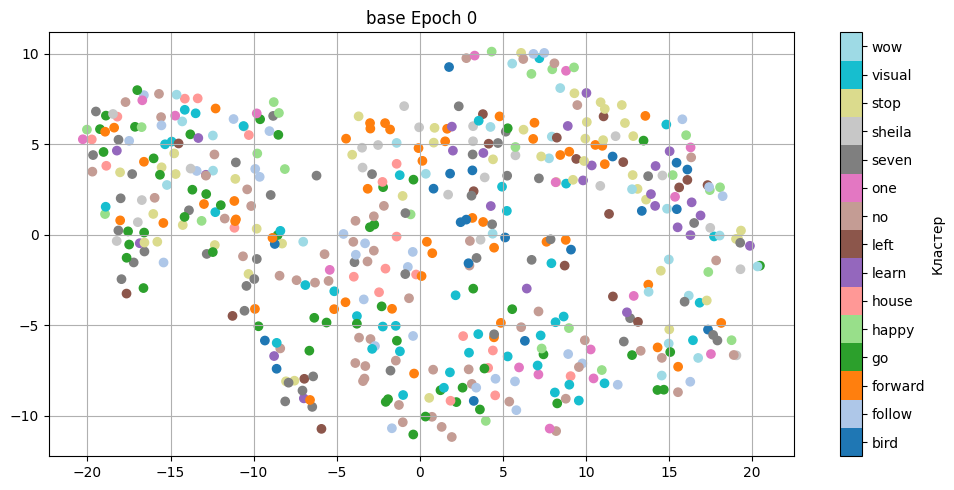

started: ./checkpoints/base/check_24
X embed shape: torch.Size([500, 64])


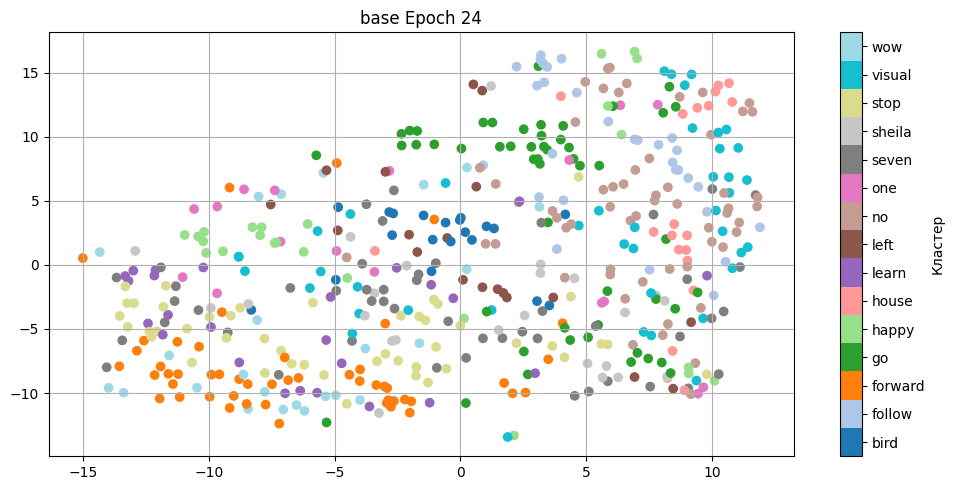

In [12]:
# models_train_metric = {'lifted_1': pd.DataFrame(columns=['epoch', 'fc', 'hv', 'hv_max']),
#           'lifted_2': pd.DataFrame(columns=['epoch', 'fc', 'hv', 'hv_max']),
#           'lifted_5': pd.DataFrame(columns=['epoch', 'fc', 'hv', 'hv_max']),
#           'lifted_10': pd.DataFrame(columns=['epoch', 'fc', 'hv', 'hv_max']),
#           'triplet_1': pd.DataFrame(columns=['epoch', 'fc', 'hv', 'hv_max']),
#           'triplet_2': pd.DataFrame(columns=['epoch', 'fc', 'hv', 'hv_max']),
#           'triplet_5': pd.DataFrame(columns=['epoch', 'fc', 'hv', 'hv_max']), 
#           'triplet_10': pd.DataFrame(columns=['epoch', 'fc', 'hv', 'hv_max']), 
#           'npair_3': pd.DataFrame(columns=['epoch', 'fc', 'hv', 'hv_max']),
#           'base': pd.DataFrame(columns=['epoch', 'fc', 'hv', 'hv_max'])}

models_unknown_metric = {'lifted_1': pd.DataFrame(columns=['epoch', 'fc', 'hv', 'hv_max']),
          'lifted_2': pd.DataFrame(columns=['epoch', 'fc', 'hv', 'hv_max']),
          'lifted_5': pd.DataFrame(columns=['epoch', 'fc', 'hv', 'hv_max']),
          'lifted_10': pd.DataFrame(columns=['epoch', 'fc', 'hv', 'hv_max']),
          'triplet_1': pd.DataFrame(columns=['epoch', 'fc', 'hv', 'hv_max']),
          'triplet_2': pd.DataFrame(columns=['epoch', 'fc', 'hv', 'hv_max']),
          'triplet_5': pd.DataFrame(columns=['epoch', 'fc', 'hv', 'hv_max']), 
          'triplet_10': pd.DataFrame(columns=['epoch', 'fc', 'hv', 'hv_max']), 
          'npair_3': pd.DataFrame(columns=['epoch', 'fc', 'hv', 'hv_max']),
          'base': pd.DataFrame(columns=['epoch', 'fc', 'hv', 'hv_max'])}

batch = next(iter(loader))

x_batch, y_batch = batch

x_batch = x_batch.to(device)
y_batch = y_batch.to(device)

with torch.no_grad():
    for model_name in models_unknown_metric.keys():
        df = models_unknown_metric[model_name]
        path_prefix = './checkpoints/' + model_name + '/'
        for i in [0, 24, 49]:
            model_path = path_prefix + f'check_{i}'
            if not os.path.isfile(model_path):
                continue
            print('started: ' + model_path)

            model = DSCNNembedModel()

            checkpoint = torch.load(model_path, map_location='cpu')
            model.load_state_dict(checkpoint['model_state_dict'], strict=False)

            model.to(device)

            sum_fc = 0.
            sum_hv = 0.
            sum_hv_max = 0.

            for j in range(1):
                x_embed = model(x_batch)

                x_embed_np = x_embed.numpy()
                y_batch_text = []
                for label_n in y_batch:
                    y_batch_text.append(google_speech_dataset.num_to_label(int(label_n)))
                y_batch_text = np.array(y_batch_text)
        
                print(f'X embed shape: {x_embed.shape}')
                TSNE_data = TSNE(n_components=2, perplexity=50, early_exaggeration=22).fit_transform(x_embed_np)
                plot_2d_data(TSNE_data, y_batch.numpy(), y_batch_text, title =model_name + " Epoch " + str(i), file_name="tsne/test_" + model_name + "_" + str(i + 1) + ".png")

                metric_fc = clustering_metric_fc(torch.from_numpy(TSNE_data), y_batch)
                metric_hv, metric_hv_max  = clustering_metric_hv(torch.from_numpy(TSNE_data), y_batch)

                sum_fc += metric_fc
                sum_hv += metric_hv
                sum_hv_max += metric_hv_max

            # sum_fc = float(sum_fc / 10)
            # sum_hv = float(sum_hv / 10)
            # sum_hv_max = float(sum_hv_max / 10)

            df_new = pd.DataFrame({'epoch':[i], 'fc':[sum_fc], 'hv': [sum_hv], 'hv_max': [sum_hv_max]})
            df = pd.concat([df, df_new])

        models_unknown_metric[model_name] = df

In [80]:
for key in models_train_metric.keys():
    print(key)
    models_train_metric[key]['fc'] = models_train_metric[key]['fc'].astype('float')
    models_train_metric[key]['hv'] = models_train_metric[key]['hv'].astype('float')
    models_train_metric[key]['hv_max'] = models_train_metric[key]['hv_max'].astype('float')
    print(models_train_metric[key])
    print()

lifted_1
  epoch        fc        hv    hv_max
0     0  0.935430  0.588614  1.000000
0    24  0.334026  0.411464  0.994566
0    49  0.232860  0.330691  0.999013

lifted_2
  epoch        fc        hv    hv_max
0     0  1.867966  0.574313  0.999991
0    24  0.319331  0.440934  0.999788
0    49  0.368858  0.435699  1.000000

lifted_5
  epoch        fc        hv    hv_max
0     0  1.798003  0.681947  0.999224
0    24  0.568303  0.432680  0.999945
0    49  0.349447  0.452066  0.998930

lifted_10
  epoch        fc        hv    hv_max
0     0  3.758792  0.654272  0.999976
0    24  0.264917  0.339674  0.999147
0    49  0.293201  0.346066  0.999931

triplet_1
  epoch        fc        hv    hv_max
0     0  3.977385  0.735813  0.999968
0    24  0.365103  0.409137  0.999083

triplet_2
  epoch        fc       hv    hv_max
0     0  4.014321  0.71291  0.999973
0    24  0.435916  0.45567  0.999841

triplet_5
  epoch        fc        hv    hv_max
0     0  5.717037  0.736703  0.999860
0    24  0.501322 

In [81]:

for key in models_unknown_metric.keys():
    print(key)
    models_unknown_metric[key]['fc'] = models_unknown_metric[key]['fc'].astype('float')
    models_unknown_metric[key]['hv'] = models_unknown_metric[key]['hv'].astype('float')
    models_unknown_metric[key]['hv_max'] = models_unknown_metric[key]['hv_max'].astype('float')
    print(models_unknown_metric[key])
    print()

lifted_1
  epoch        fc        hv    hv_max
0     0  2.263025  0.634223  0.999903
0    24  1.429228  0.564248  0.998998
0    49  0.874675  0.536035  0.999966

lifted_2
  epoch        fc        hv    hv_max
0     0  1.909302  0.586785  0.999749
0    24  1.339582  0.639503  0.999999
0    49  1.234520  0.582035  0.999750

lifted_5
  epoch        fc        hv    hv_max
0     0  2.010137  0.609129  1.000000
0    24  0.871218  0.525405  0.999974
0    49  1.153610  0.529756  0.999424

lifted_10
  epoch        fc        hv    hv_max
0     0  3.499104  0.672144  0.999544
0    24  1.207792  0.516644  0.999898
0    49  0.901098  0.481350  0.997695

triplet_1
  epoch        fc        hv    hv_max
0     0  8.871874  0.739887  0.999531
0    24  1.387805  0.597639  0.999982

triplet_2
  epoch         fc        hv    hv_max
0     0  15.092115  0.629426  0.999906
0    24   1.426392  0.531548  0.995802

triplet_5
  epoch         fc        hv    hv_max
0     0  18.825047  0.734599  1.000000
0    24   

In [ ]:
for key in model_perfomance_test:
    model_perfomance_test[key].to_csv("csv/unknown_perfomance_" + key + ".csv")
for key in model_perfomance_train:
    model_perfomance_train[key].to_csv("csv/train_perfomance_" + key + ".csv")

In [ ]:
google_speech_dataset = GoogleSpeechDataset(csv_file=test_labels_csv_filename, root_dir="./speech_commands/", transform=None)
label_ids = {}
all_label_inddices = google_speech_dataset.get_classes()
labels = google_speech_dataset.get_labels()
label_ids_np = np.zeros((15, 5))
for i, label in enumerate(labels):
    label_ids_np[i] = label_ids[label] = np.random.choice(np.array(all_label_inddices[i]), size=5, replace=False).astype(int)

    if i == 14:
        break
label_ids_np = label_ids_np.astype(int)

In [ ]:
labels

In [ ]:
label_ids

In [ ]:
label_ids_np

In [ ]:
label_ids_np_flat = label_ids_np.flatten()
labels_flat = []
for i in range(15):
    for j in range(5):
        labels_flat.append(i)
labels_np_flat = np.array(labels_flat).astype(int)

In [ ]:
device

In [ ]:
batch = []
for i in label_ids_np_flat:
    sample, label = google_speech_dataset.__getitem__(i)

    if len(batch) == 0:
        batch.append(sample.unsqueeze(1))
        batch.append(label)
    else:
        batch[0] = torch.vstack((batch[0], sample.unsqueeze(1)))
        batch[1] = torch.hstack((batch[1], label))

batch[0] = batch[0].to(device)
batch[1] = batch[1].to(device)


In [ ]:
batch[0].shape

In [ ]:
model_names = list(models_train_metric.keys())
model_names

In [ ]:
model_perfomance_test = {'lifted_1': pd.DataFrame(columns=['epoch', 'correct', 'all', 'accuracy', 'prediction_matix']),
                            'lifted_2': pd.DataFrame(columns=['epoch', 'correct', 'all', 'accuracy', 'prediction_matix']),
                            'lifted_5': pd.DataFrame(columns=['epoch', 'correct', 'all', 'accuracy', 'prediction_matix']),
                            'lifted_10': pd.DataFrame(columns=['epoch', 'correct', 'all', 'accuracy', 'prediction_matix']),
                            'triplet_1': pd.DataFrame(columns=['epoch', 'correct', 'all', 'accuracy', 'prediction_matix']),
                            'triplet_2': pd.DataFrame(columns=['epoch', 'correct', 'all', 'accuracy', 'prediction_matix']),
                            'triplet_5': pd.DataFrame(columns=['epoch', 'correct', 'all', 'accuracy', 'prediction_matix']), 
                            'triplet_10': pd.DataFrame(columns=['epoch', 'correct', 'all', 'accuracy', 'prediction_matix']), 
                            'npair_3': pd.DataFrame(columns=['epoch', 'correct', 'all', 'accuracy', 'prediction_matix']),
                            'base': pd.DataFrame(columns=['epoch', 'correct', 'all', 'accuracy', 'prediction_matix'])}

for model_name in model_names:
    df = model_perfomance_test[model_name]
    path_prefix = './checkpoints/' + model_name + '/'
    for i in range(0, 100):
        model_path = path_prefix + f'check_{i}'
        if not os.path.isfile(model_path):
            continue
        print('started: ' + model_path)

        model = DSCNNembedModel()

        checkpoint = torch.load(model_path)
        model.load_state_dict(checkpoint['model_state_dict'], strict=False)

        model.to(device)

        embeddings = model(batch[0])
        centers = embeddings[[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]]
        
        pairwise_dist = torch.cdist(embeddings, centers)
        prediction = torch.argmin(pairwise_dist, dim=1)
        pred_table = np.zeros((15,15), int)

        for j in range(prediction.shape[0]):
            pred_table[batch[1][j], prediction[j]] += 1

        correct_count = pred_table.diagonal().sum() - pred_table.shape[0]
        all_pred_count = pred_table.sum() - pred_table.shape[0]
        accuracy = correct_count / all_pred_count

        df_new = pd.DataFrame({'epoch':[i], 'correct':[correct_count], 'all': [all_pred_count], 'accuracy': [accuracy], 'prediction_matix': [[pred_table]]})
        df = pd.concat([df, df_new])

    model_perfomance_test[model_name] = df


In [ ]:
model_perfomance_train['lifted_10']

In [ ]:
model_perfomance_test['base']

In [ ]:
m_table = np.zeros((10, 10), int)
x = [0, 0, 3, 6]
y = [0, 0, 3, 6]
m_table[x, y] += 1
m_table

### Aggregate csv

In [26]:
models_aggregate = {'lifted_1': pd.DataFrame(columns=['epoch', 'train_fc', 'train_hv', 'train_hv_max', 'unknown_fc', 'unknown_hv', 'unknown_hv_max', 'train_correct', 'train_all', 'train_accuracy', 'train_prediction_matix', 'unknown_correct', 'unknown_all', 'unknown_accuracy', 'unknown_prediction_matix']),
                    'lifted_5': pd.DataFrame(columns=['epoch', 'train_fc', 'train_hv', 'train_hv_max', 'unknown_fc', 'unknown_hv', 'unknown_hv_max', 'train_correct', 'train_all', 'train_accuracy', 'train_prediction_matix', 'unknown_correct', 'unknown_all', 'unknown_accuracy', 'unknown_prediction_matix']),
                    'lifted_2': pd.DataFrame(columns=['epoch', 'train_fc', 'train_hv', 'train_hv_max', 'unknown_fc', 'unknown_hv', 'unknown_hv_max', 'train_correct', 'train_all', 'train_accuracy', 'train_prediction_matix', 'unknown_correct', 'unknown_all', 'unknown_accuracy', 'unknown_prediction_matix']),
                    'lifted_10': pd.DataFrame(columns=['epoch', 'train_fc', 'train_hv', 'train_hv_max', 'unknown_fc', 'unknown_hv', 'unknown_hv_max', 'train_correct', 'train_all', 'train_accuracy', 'train_prediction_matix', 'unknown_correct', 'unknown_all', 'unknown_accuracy', 'unknown_prediction_matix']),
                    'triplet_1': pd.DataFrame(columns=['epoch', 'train_fc', 'train_hv', 'train_hv_max', 'unknown_fc', 'unknown_hv', 'unknown_hv_max', 'train_correct', 'train_all', 'train_accuracy', 'train_prediction_matix', 'unknown_correct', 'unknown_all', 'unknown_accuracy', 'unknown_prediction_matix']),
                    'triplet_2': pd.DataFrame(columns=['epoch', 'train_fc', 'train_hv', 'train_hv_max', 'unknown_fc', 'unknown_hv', 'unknown_hv_max', 'train_correct', 'train_all', 'train_accuracy', 'train_prediction_matix', 'unknown_correct', 'unknown_all', 'unknown_accuracy', 'unknown_prediction_matix']),
                    'triplet_5': pd.DataFrame(columns=['epoch', 'train_fc', 'train_hv', 'train_hv_max', 'unknown_fc', 'unknown_hv', 'unknown_hv_max', 'train_correct', 'train_all', 'train_accuracy', 'train_prediction_matix', 'unknown_correct', 'unknown_all', 'unknown_accuracy', 'unknown_prediction_matix']), 
                    'triplet_10': pd.DataFrame(columns=['epoch', 'train_fc', 'train_hv', 'train_hv_max', 'unknown_fc', 'unknown_hv', 'unknown_hv_max', 'train_correct', 'train_all', 'train_accuracy', 'train_prediction_matix', 'unknown_correct', 'unknown_all', 'unknown_accuracy', 'unknown_prediction_matix']), 
                    'npair_3': pd.DataFrame(columns=['epoch', 'train_fc', 'train_hv', 'train_hv_max', 'unknown_fc', 'unknown_hv', 'unknown_hv_max', 'train_correct', 'train_all', 'train_accuracy', 'train_prediction_matix', 'unknown_correct', 'unknown_all', 'unknown_accuracy', 'unknown_prediction_matix']),
                    'base': pd.DataFrame(columns=['epoch', 'train_fc', 'train_hv', 'train_hv_max', 'unknown_fc', 'unknown_hv', 'unknown_hv_max', 'train_correct', 'train_all', 'train_accuracy', 'train_prediction_matix', 'unknown_correct', 'unknown_all', 'unknown_accuracy', 'unknown_prediction_matix'])}

In [27]:
models_aggregate.keys()

dict_keys(['lifted_1', 'lifted_5', 'lifted_2', 'lifted_10', 'triplet_1', 'triplet_2', 'triplet_5', 'triplet_10', 'npair_3', 'base'])

In [28]:
csv_dir = './csv/'
csv_prefixes = ['train_', 'train_perfomance_', 'unknown_', 'unknown_perfomance_']
columns_aggregate = [['epoch', 'train_fc', 'train_hv', 'train_hv_max'], ['train_correct', 'train_all', 'train_accuracy', 'train_prediction_matix'], ['unknown_fc', 'unknown_hv', 'unknown_hv_max'], ['unknown_correct', 'unknown_all', 'unknown_accuracy', 'unknown_prediction_matix']]
columns = [['epoch','fc', 'hv', 'hv_max'], ['correct', 'all', 'accuracy', 'prediction_matix'], ['fc', 'hv', 'hv_max'], ['correct', 'all', 'accuracy', 'prediction_matix']]


for model_name in models_aggregate.keys():
    for i, prefix in enumerate(csv_prefixes):
        path = csv_dir + prefix + model_name + '.csv'
        df = pd.read_csv(path)
        
        for j in range(len(columns_aggregate[i])):
            models_aggregate[model_name][columns_aggregate[i][j]] = df[columns[i][j]]


In [32]:
csv_columns = ['epoch', 'train_fc', 'train_hv', 'train_hv_max', 'unknown_fc', 'unknown_hv', 'unknown_hv_max', 'train_correct', 'train_all', 'train_accuracy', 'unknown_correct', 'unknown_all', 'unknown_accuracy']
for model_name in models_aggregate.keys():
    models_aggregate[model_name].to_csv('./csv/aggregate_' + model_name + '.csv', columns=csv_columns, index=False)

In [29]:
models_aggregate['base']

,epoch,train_fc,train_hv,train_hv_max,unknown_fc,unknown_hv,unknown_hv_max,train_correct,train_all,train_accuracy,train_prediction_matix,unknown_correct,unknown_all,unknown_accuracy,unknown_prediction_matix
0,0,2.429726,0.643636,0.985146,3.730602,0.678417,0.982329,13,60,0.216667,NaN,6,60,0.100000,NaN
1,1,1.245497,0.617043,0.984752,2.198363,0.638209,0.981454,10,60,0.166667,NaN,10,60,0.166667,NaN
2,2,1.239822,0.600145,0.976825,1.768657,0.645103,0.986159,9,60,0.150000,NaN,8,60,0.133333,NaN
3,3,0.990540,0.588637,0.968691,1.567371,0.618753,0.977995,7,60,0.116667,NaN,10,60,0.166667,NaN
4,4,0.956624,0.575664,0.966509,1.833665,0.621700,0.966147,11,60,0.183333,NaN,9,60,0.150000,NaN
5,5,0.969541,0.581617,0.958344,1.817006,0.611043,0.965490,12,60,0.200000,NaN,10,60,0.166667,NaN
6,6,0.853712,0.559867,0.955803,1.732674,0.600654,0.953149,11,60,0.183333,NaN,13,60,0.216667,NaN
7,7,0.890040,0.554468,0.938689,1.679400,0.601427,0.952026,14,60,0.233333,NaN,14,60,0.233333,NaN
8,8,0.789221,0.544806,0.937212,1.653183,0.614010,0.952618,18,60,0.300000,NaN,16,60,0.266667,NaN
9,9,0.804548,0.524929,0.940119,1.588998,0.605348,0.949572,18,60,0.300000,NaN,16,60,0.266667,NaN


In [ ]:
import os
import numpy as np
import pandas as pd

from collections import defaultdict
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator


def tabulate_events(dpath):
    summary_iterators = [EventAccumulator(os.path.join(dpath, dname)).Reload() for dname in os.listdir(dpath)]

    tags = summary_iterators[0].Tags()['scalars']

    for it in summary_iterators:
        assert it.Tags()['scalars'] == tags

    out = defaultdict(list)
    steps = []

    for tag in tags:
        steps = [e.step for e in summary_iterators[0].Scalars(tag)]

        for events in zip(*[acc.Scalars(tag) for acc in summary_iterators]):
            assert len(set(e.step for e in events)) == 1

            out[tag].append([e.value for e in events])

    return out, steps


def to_csv(dpath):
    dirs = os.listdir(dpath)

    d, steps = tabulate_events(dpath)
    tags, values = zip(*d.items())
    np_values = np.array(values)

    for index, tag in enumerate(tags):
        df = pd.DataFrame(np_values[index], index=steps, columns=dirs)
        df.to_csv(get_file_path(dpath, tag))


def get_file_path(dpath, tag):
    file_name = tag.replace("/", "_") + '.csv'
    folder_path = os.path.join(dpath, 'csv')
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    return os.path.join(folder_path, file_name)


to_csv('./logs/')

## TSNE